In [3]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "bq_auth.json"

import datetime
import calendar
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re

In [4]:
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
stackOverflow = bq_helper.BigQueryHelper(active_project="krawling1111",
                                   dataset_name="stackoverflow")

In [5]:
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")
bq_assistant.list_tables()

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [20]:
bq_assistant.head("posts_questions", num_rows=20)

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,post_type_id,score,tags,view_count
0,47309613,Issue with the webpack-bundler,<p>I am trying to compile all my tsx files whi...,NaN,1,1,None,2017-11-15 14:11:29.557000+00:00,NaN,2017-11-15 14:23:45.703000+00:00,NaT,,NaN,,7614689,1,0,webpack,172
1,36953265,Reducing queries on Firebase,<p>I have the following problem:\nI have a lis...,NaN,0,3,None,2016-04-30 09:42:32.243000+00:00,NaN,2016-04-30 09:42:32.243000+00:00,NaT,,NaN,,5282695,1,0,javascript|firebase,40
2,35547622,Passing a Matrix from C++ to MATLAB,<p>I've reviewed questions with similar (almos...,NaN,0,7,None,2016-02-22 07:05:17.407000+00:00,NaN,2016-02-22 07:35:20.247000+00:00,2016-02-22 07:35:20.247000+00:00,,3855264.0,,3855264,1,1,c++|matlab|matrix,265
3,3474037,window.onload vs. body.onload vs. document.onr...,<p>What is the difference between <code>window...,3474078.0,1,5,None,2010-08-13 05:04:18.247000+00:00,14.0,2015-09-14 15:09:30.797000+00:00,2013-08-21 23:47:28.477000+00:00,,31671.0,,341144,1,73,javascript,65978
4,33749987,How to display two fragments vertically (maste...,<p>I'm trying to display information by select...,NaN,1,2,None,2015-11-17 05:46:14.160000+00:00,NaN,2015-11-17 06:38:25.550000+00:00,2015-11-17 06:38:25.550000+00:00,,4548981.0,,5548090,1,2,android|android-layout|listview|android-fragments,107
5,50017442,How to pass data from servlet to JSP without f...,<p>I am trying to pass the data from servlet t...,NaN,0,4,None,2018-04-25 08:27:23.120000+00:00,NaN,2018-04-25 08:38:25.220000+00:00,2018-04-25 08:38:25.220000+00:00,,4428158.0,,4428158,1,0,java|jsp|servlets|jstl,35
6,40508262,collection from customer model is not retrievi...,<p>i have created one custom front end module ...,40651321.0,1,0,None,2016-11-09 13:33:03.030000+00:00,NaN,2016-11-17 09:39:01.460000+00:00,2016-11-09 13:39:43.427000+00:00,,3395306.0,,3395306,1,1,collections|model|magento2,113
7,34119227,I need to generate and display a random number...,<p>I'm a student at a community college. The ...,NaN,0,0,None,2015-12-06 15:39:50.630000+00:00,NaN,2015-12-06 15:39:50.630000+00:00,NaT,,NaN,,4819316,1,1,java|android|random,41
8,49123760,Cannot resolve bundle style,<p>I'm trying to integrate Webpack into my Dja...,NaN,0,1,None,2018-03-06 05:08:36.857000+00:00,NaN,2018-03-06 05:08:36.857000+00:00,NaT,,NaN,,7583514,1,3,python|django|webpack,220
9,43436322,Python run set.intersection with set of sets a...,"<p>I am working with biological datasets, stra...",NaN,0,7,None,2017-04-16 10:40:34.117000+00:00,NaN,2017-04-16 11:27:41.397000+00:00,2017-04-16 11:27:41.397000+00:00,,7874166.0,,7874166,1,0,python-2.7,36


In [4]:
bq_assistant.head("posts_answers", num_rows=20)

,id,body,comment_count,community_owned_date,creation_date,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags
0,17147316,<p>Attach the <code>Mylocation.txt</code> as r...,1,None,2013-06-17 12:18:56.827000+00:00,2013-06-17 12:18:56.827000+00:00,NaT,,NaN,,1124244,17143806,2,0,
1,36356211,<p>Templates must ideally be implemented inlin...,0,None,2016-04-01 12:20:55.963000+00:00,2016-04-01 12:20:55.963000+00:00,NaT,,NaN,,264325,36356136,2,1,
2,29997584,<p>You can do it by creating a json encoded re...,4,None,2015-05-02 02:07:12.093000+00:00,2015-05-02 02:07:12.093000+00:00,NaT,,NaN,,987447,29997439,2,1,
3,15701054,"<p>The ""classical"" Java problem also affects m...",1,None,2013-03-29 10:01:10.730000+00:00,2013-03-29 10:01:10.730000+00:00,NaT,,NaN,,1016146,2598009,2,1,
4,468912,"<p>Another alternative, if you know the time b...",0,None,2009-01-22 12:24:51.253000+00:00,2009-01-22 12:24:51.253000+00:00,NaT,,NaN,xan,15667,468779,2,1,
5,35976431,<p><code>sizeof()</code> gives you the size of...,4,None,2016-03-13 22:02:32.670000+00:00,2016-03-13 22:02:32.670000+00:00,NaT,,NaN,,3943312,35976374,2,2,
6,37534810,<p>The Phoenix.Presence docs are available her...,1,None,2016-05-30 23:34:30.030000+00:00,2016-05-30 23:34:30.030000+00:00,NaT,,NaN,,2355214,37532569,2,1,
7,49414118,<p>Try to store the indices and do the updatin...,1,None,2018-03-21 18:32:35.733000+00:00,2018-03-21 18:32:35.733000+00:00,NaT,,NaN,,3741892,49413782,2,2,
8,36524183,"<p>Your basic approach is correct, although I ...",6,None,2016-04-09 23:58:18.040000+00:00,2016-04-10 00:02:20.027000+00:00,2016-04-10 00:02:20.027000+00:00,,3973077.0,,3973077,36524123,2,1,
9,4049611,<blockquote>\n <p>Would not it be much more e...,0,None,2010-10-29 06:45:55.143000+00:00,2010-10-29 06:45:55.143000+00:00,NaT,,NaN,,191708,4049179,2,1,


In [32]:
query = """SELECT questions.score, questions.view_count, answers.score as ans_score, questions.creation_date, questions.tags,
            TIMESTAMP_DIFF(answers.creation_date, questions.creation_date, MINUTE) as TimeDiff
    FROM `bigquery-public-data.stackoverflow.posts_questions` questions
    LEFT JOIN `bigquery-public-data.stackoverflow.posts_answers` answers ON questions.accepted_answer_id = answers.id
    WHERE EXTRACT(YEAR FROM questions.creation_date) >=2016 AND questions.accepted_answer_id IS NOT NULL
        """

In [33]:
bq_assistant.estimate_query_size(query)

1.4091843171045184

In [34]:
response = stackOverflow.query_to_pandas(query)

In [36]:
response.head(10)

,score,view_count,ans_score,creation_date,tags,TimeDiff
0,54,24645,108,2016-06-17 11:51:36.373000+00:00,angular|angular2-routing,0
1,7,5207,12,2016-03-13 23:07:48.857000+00:00,c#|.net|winforms|entity-framework|datagridview,176
2,10,4576,24,2016-06-21 11:56:37.690000+00:00,python|pandas|dataframe|redis,863
3,14,6953,19,2016-03-30 14:32:49.533000+00:00,c#|console|binary-tree,12671
4,8,1733,8,2017-01-19 01:41:42.253000+00:00,ios|swift|firebase|firebase-crash-reporting,12772
5,24,46820,46,2016-12-30 12:40:38.903000+00:00,angular|ionic2,9
6,13,2120,18,2016-06-30 09:01:00.913000+00:00,swift|initialization|lazy-initialization,22
7,8,1977,9,2017-11-30 22:56:36.830000+00:00,node.js|sdk|api.ai|dialogflow,7461
8,16,29043,38,2016-05-28 10:51:46.660000+00:00,data-binding|angular|angular2-template,34
9,7,1913,10,2017-01-03 15:02:12.307000+00:00,javascript|openlayers-3,358


In [12]:
response.to_csv("data.csv", index=False)

In [65]:
response = pd.read_csv("data.csv")

In [66]:
response.describe()

,score,view_count,ans_score,TimeDiff
count,2.589841e+06,2.589841e+06,2.589841e+06,2.589841e+06
mean,9.028994e-01,5.524078e+02,1.833895e+00,6.127232e+03
std,4.468586e+00,2.828174e+03,6.477772e+00,4.490455e+04
min,-6.500000e+01,3.000000e+00,-1.400000e+01,0.000000e+00
25%,0.000000e+00,5.000000e+01,0.000000e+00,1.100000e+01
50%,0.000000e+00,1.050000e+02,1.000000e+00,4.200000e+01
75%,1.000000e+00,3.490000e+02,2.000000e+00,3.520000e+02
max,2.267000e+03,6.427520e+05,3.108000e+03,1.395281e+06


In [67]:
response.shape

(2589841, 6)

In [68]:
response['creation_date'] = pd.to_datetime(response['creation_date'])

In [69]:
response['creation_date'] = response['creation_date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [70]:
response.tags = response.tags.fillna('NA')

In [71]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [72]:
add_datepart(response, 'creation_date')

In [73]:
response.head()

,score,view_count,ans_score,tags,TimeDiff,creation_Year,creation_Month,creation_Week,creation_Day,creation_Dayofweek,creation_Dayofyear,creation_Is_month_end,creation_Is_month_start,creation_Is_quarter_end,creation_Is_quarter_start,creation_Is_year_end,creation_Is_year_start,creation_Elapsed
0,54,24645,108,angular|angular2-routing,0,2016,6,24,17,4,169,False,False,False,False,False,False,1466164296
1,7,5207,12,c#|.net|winforms|entity-framework|datagridview,176,2016,3,10,13,6,73,False,False,False,False,False,False,1457910468
2,10,4576,24,python|pandas|dataframe|redis,863,2016,6,25,21,1,173,False,False,False,False,False,False,1466510197
3,14,6953,19,c#|console|binary-tree,12671,2016,3,13,30,2,90,False,False,False,False,False,False,1459348369
4,8,1733,8,ios|swift|firebase|firebase-crash-reporting,12772,2017,1,3,19,3,19,False,False,False,False,False,False,1484790102


In [74]:
tag_list = response.tags.apply(lambda x: x.split('|'))
array_list = np.array(tag_list)
flatten = lambda l: [item for sublist in l for item in sublist]
flat_list = flatten(array_list)
from collections import Counter
freq = Counter(flat_list)
sorted_x = sorted(freq.items(), key=lambda kv: kv[1],reverse=True)
pop_list= []
for i,j in sorted_x[:50]:
    pop_list.append(i)

In [75]:
pop_list

['javascript',
 'python',
 'java',
 'c#',
 'php',
 'html',
 'android',
 'jquery',
 'css',
 'c++',
 'sql',
 'ios',
 'mysql',
 'r',
 'arrays',
 'swift',
 'node.js',
 'angular',
 'json',
 'angularjs',
 'sql-server',
 'python-3.x',
 'c',
 'reactjs',
 'pandas',
 'regex',
 'excel',
 'ruby-on-rails',
 'django',
 'laravel',
 'vba',
 'typescript',
 'asp.net',
 'ruby',
 'xml',
 'string',
 'ajax',
 'bash',
 '.net',
 'linux',
 'spring',
 'asp.net-mvc',
 'excel-vba',
 'python-2.7',
 'firebase',
 'scala',
 'postgresql',
 'mongodb',
 'wordpress',
 'twitter-bootstrap']

In [76]:
response.TimeDiff.describe()

count    2.589841e+06
mean     6.127232e+03
std      4.490455e+04
min      0.000000e+00
25%      1.100000e+01
50%      4.200000e+01
75%      3.520000e+02
max      1.395281e+06
Name: TimeDiff, dtype: float64

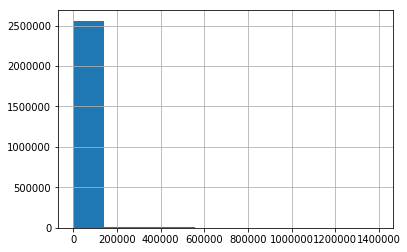

In [77]:
hist = response['TimeDiff'].hist()

In [78]:
bins = [-1, 6, 12, 24, 72, 168, response['TimeDiff'].max()]
group_names = list(range(6))
target = pd.cut(response['TimeDiff'], bins, labels=group_names)

In [79]:
target

0          0
1          5
2          5
3          5
4          5
5          1
6          2
7          5
8          3
9          5
10         3
11         4
12         1
13         3
14         0
15         5
16         5
17         2
18         3
19         5
20         2
21         0
22         2
23         2
24         2
25         4
26         5
27         5
28         4
29         5
          ..
2589811    3
2589812    1
2589813    3
2589814    4
2589815    5
2589816    4
2589817    5
2589818    5
2589819    2
2589820    0
2589821    2
2589822    1
2589823    5
2589824    5
2589825    4
2589826    1
2589827    0
2589828    5
2589829    1
2589830    1
2589831    0
2589832    5
2589833    2
2589834    4
2589835    1
2589836    0
2589837    5
2589838    0
2589839    3
2589840    3
Name: TimeDiff, Length: 2589841, dtype: category
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

In [88]:
y = response['TimeDiff'] <= 60
y = y.values

In [82]:
response.head()

,score,view_count,ans_score,tags,TimeDiff,creation_Year,creation_Month,creation_Week,creation_Day,creation_Dayofweek,creation_Dayofyear,creation_Is_month_end,creation_Is_month_start,creation_Is_quarter_end,creation_Is_quarter_start,creation_Is_year_end,creation_Is_year_start,creation_Elapsed
0,54,24645,108,angular|angular2-routing,0,2016,6,24,17,4,169,False,False,False,False,False,False,1466164296
1,7,5207,12,c#|.net|winforms|entity-framework|datagridview,176,2016,3,10,13,6,73,False,False,False,False,False,False,1457910468
2,10,4576,24,python|pandas|dataframe|redis,863,2016,6,25,21,1,173,False,False,False,False,False,False,1466510197
3,14,6953,19,c#|console|binary-tree,12671,2016,3,13,30,2,90,False,False,False,False,False,False,1459348369
4,8,1733,8,ios|swift|firebase|firebase-crash-reporting,12772,2017,1,3,19,3,19,False,False,False,False,False,False,1484790102


In [83]:
from sklearn.preprocessing import MultiLabelBinarizer
response['tags'] = response.tags.str.split('|')
tags = response['tags'].apply(lambda x: list(set(x) & set(pop_list)))
mlb = MultiLabelBinarizer()
tag = pd.DataFrame(mlb.fit_transform(tags), columns=mlb.classes_, index = tags.index)

In [84]:
tag.shape

(2589841, 50)

In [85]:
df = pd.concat([response, tag], axis=1)

In [86]:
df = df.drop(columns=['TimeDiff', 'tags'])

In [87]:
# one-hot encoding categorical variables
X = pd.get_dummies(df).values
X

array([[54, 24645, 108, ..., 0, 0, 0],
       [7, 5207, 12, ..., 0, 0, 0],
       [10, 4576, 24, ..., 0, 0, 0],
       ...,
       [-1, 62, -1, ..., 0, 0, 0],
       [-1, 68, -1, ..., 0, 0, 0],
       [-1, 113, -1, ..., 0, 0, 0]], dtype=object)

In [28]:
y = np.array(target.values)
y

array([1, 6, 6, ..., 1, 4, 4], dtype=int64)

In [90]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 516)

In [92]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# A parameter grid for XGBoost
params = {
    'min_child_weight':list(range(3,7,1)), 
    'max_depth': list(range(3,9,1)),
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma':[0, 0.05, 0.1],  
    'subsample':[0.8],
    'colsample_bytree':[0.8], 
    'n_estimators': [100]
}

#dtrain = xgb.DMatrix(X_train, y_train)

# Initialize XGB and GridSearch
gbm = xgb.XGBClassifier(silent=False, objective='gpu:binary:hinge', tree_method='gpu_hist')

grid = GridSearchCV(gbm, params, verbose=True, n_jobs=-1)

In [ ]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [178]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:hinge', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.8, tree_method='gpu_hist')

In [46]:
xgb_best = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=-1, nthread=12, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, num_class = 7,
       silent=False, subsample=0.8, tree_method='gpu_hist')
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=500,
       n_jobs=-1, nthread=12, num_class=7, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.8, tree_method='gpu_hist')

In [47]:
y_train_pred = xgb_best.predict(X_train)

In [48]:
y_train_pred

array([6., 6., 6., ..., 6., 1., 6.], dtype=float32)

[9.22394916e-02 1.39050439e-01 1.36190295e-01 3.28916009e-03
 1.71608350e-03 9.34312120e-03 1.21079227e-02 2.21184101e-02
 2.38344930e-02 7.62703770e-04 9.53379713e-05 3.81351885e-04
 5.24358824e-04 4.76689856e-05 3.81351885e-04 6.92153722e-02
 1.00104872e-03 1.09638670e-03 2.67899707e-02 1.21555915e-02
 7.38869281e-03 1.02011627e-02 1.23939360e-03 2.81247031e-03
 7.62703782e-03 9.62913502e-03 2.13557053e-02 1.82572212e-02
 1.94966160e-02 4.95757442e-03 9.00943857e-03 1.52540754e-03
 6.24463707e-03 1.35379918e-02 7.91305210e-03 2.41681766e-02
 4.62389179e-02 1.36809992e-02 5.86328516e-03 5.57727134e-03
 7.62703770e-04 7.19801709e-03 1.04871774e-02 6.05396135e-03
 9.05710738e-03 1.84955671e-02 2.43111840e-03 2.97454484e-02
 1.28706265e-03 4.67156060e-03 1.38716754e-02 7.38869281e-03
 9.96281859e-03 4.14720178e-03 6.86433399e-03 8.62808619e-03
 3.86118796e-03 1.33473165e-02 7.00734090e-03 7.29335472e-03
 1.15358951e-02 3.67051200e-03 2.62179435e-03 7.24568591e-03
 5.43426443e-03 7.865382

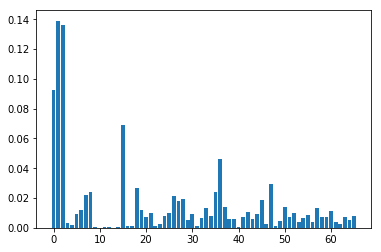

In [49]:
# feature importance
print(xgb_best.feature_importances_)

# plot
plt.bar(range(len(xgb_best.feature_importances_)), xgb_best.feature_importances_)
plt.show()

In [50]:
y_test_pred = xgb_best.predict(X_test)

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[ 36641,    347,    352,   7546,      0,  33439],
       [ 21533,    350,    360,   7512,      0,  32588],
       [ 18149,    350,    408,   8687,      0,  41002],
       [ 17124,    351,    405,  11255,      1,  64216],
       [  6251,    124,    132,   5050,      0,  40285],
       [  9392,    148,    195,   7400,      0, 146376]], dtype=int64)

In [54]:
from sklearn.metrics import roc_curve
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported

LASSO

In [41]:
from sklearn import linear_model
lassoCV = linear_model.LassoCV(cv=10, random_state=123, n_jobs=-1,max_iter=100000, normalize=True)
lassoCV.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=-1, normalize=True,
    positive=False, precompute='auto', random_state=123,
    selection='cyclic', tol=0.0001, verbose=False)

In [42]:
lasso = linear_model.Lasso(max_iter=10000, normalize=True)
lasso.set_params(alpha=lassoCV.alpha_)
lasso.fit(X_train, y_train)

Lasso(alpha=1.1505016420194474, copy_X=True, fit_intercept=True,
   max_iter=10000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
y_train_pred = lasso.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train_pred, y_train))
train_rmse

30255.538979871922

In [44]:
y_test_pred = lasso.predict(X_test)
test_rmse = math.sqrt(mean_squared_error(y_test_pred, y_test))
test_rmse

30109.714616227866